In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import glob
references = glob.glob('/data/datasets/real_tubface_99/8-bit sRGB Processed/*None_PC00C00*.tif')
references.sort(key=lambda x: int(x.split('/')[-1].split('_')[1]))
references = references[:96]
references.remove('/data/datasets/real_tubface_99/8-bit sRGB Processed/PGR Flea_0082__None_PC00C00__E0_000_1-180901-141229.tif')
ref_indexs = [int(reference.split('/')[-1].split('_')[1]) for reference in references]

tubimgs = list(glob.glob('/media/viu/DISK/Turbulence_data/Range Stills/300m/*None_PC00C00*.tif'))
tubimgs.sort(key=lambda x: int(x.split('/')[-1].split('_')[1]))
new_tubimgs = []
for tubimg in tubimgs:
    index = int(tubimg.split('/')[-1].split('_')[1])
    if index in ref_indexs:
        new_tubimgs.append(tubimg)

tubimgs = new_tubimgs
print(len(references), len(tubimgs), len(tubimgs)/len(references))

95 95 1.0


In [2]:
from basicsr.utils import img2tensor, tensor2img
from torchvision.transforms.functional import normalize

from facexlib.utils.face_restoration_helper import FaceRestoreHelper
face_helper = FaceRestoreHelper(
    2,
    face_size=512,
    crop_ratio=(1.2, 1.2),
    det_model='retinaface_resnet50',
    save_ext='png',
    device='cuda:0'
)

In [3]:
import cv2
idx = 24
tub_face_img = cv2.imread(references[idx], cv2.IMREAD_UNCHANGED)
face_helper.clean_all()
face_helper.read_image(tub_face_img)
face_helper.get_face_landmarks_5(only_center_face=True)
face_helper.align_warp_face()
tub_face_img = face_helper.cropped_faces[0]
tub_face_img = cv2.resize(tub_face_img, (512, 512), cv2.INTER_LANCZOS4)

tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0')

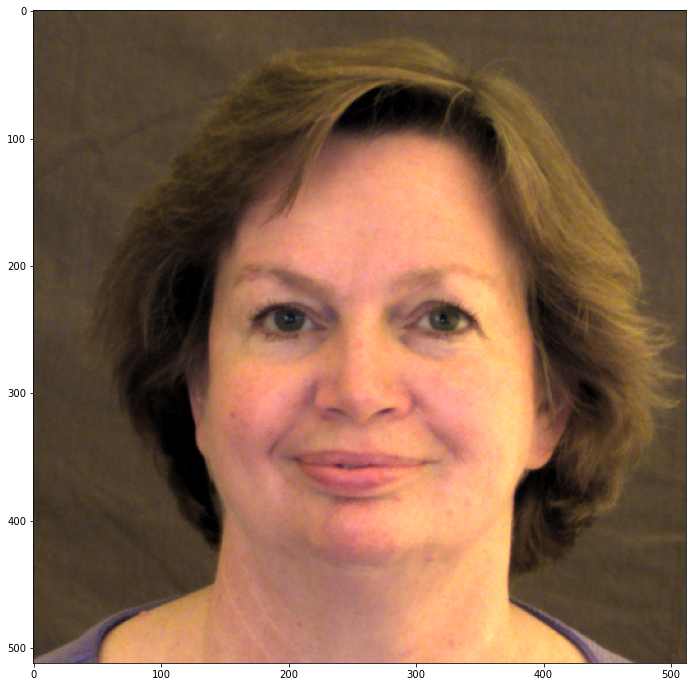

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.imshow(tensor2img(tub_face_img_th, rgb2bgr=False, min_max=(-1, 1)))

In [7]:
for index, reference in enumerate(references):
    tub_face_img = cv2.imread(reference, cv2.IMREAD_UNCHANGED)
    face_helper.clean_all()
    face_helper.read_image(tub_face_img)
    face_helper.get_face_landmarks_5(only_center_face=True)
    face_helper.align_warp_face()
    tub_face_img = face_helper.cropped_faces[0]
    tub_face_img = cv2.resize(tub_face_img, (512, 512), cv2.INTER_LANCZOS4)

    tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
    normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
    tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0')
    tub_face_img = tensor2img(tub_face_img_th, rgb2bgr=True, min_max=(-1, 1))
    cv2.imwrite(os.path.join('/data/datasets/Tubfaces95/references/', '%02d.png' % (index+1)), tub_face_img)

In [8]:
import numpy as np
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

for index, tubimg in enumerate(tubimgs):
    tub_face_img = cv2.imread(tubimg, cv2.IMREAD_UNCHANGED).astype(np.float32)
    tub_face_img = np.uint8((tub_face_img - tub_face_img.min()) / (tub_face_img.max()-tub_face_img.min()) * 255.)
    tub_face_img = adjust_gamma(tub_face_img, 2.2)
    tub_face_img = np.clip(tub_face_img, 0, 255)
    face_helper.clean_all()
    face_helper.read_image(tub_face_img)
    face_helper.get_face_landmarks_5(only_center_face=True)
    face_helper.align_warp_face()
    tub_face_img = face_helper.cropped_faces[0]
    tub_face_img = cv2.resize(tub_face_img, (512, 512), cv2.INTER_LANCZOS4)

    tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
    normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
    tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0')
    tub_face_img = tensor2img(tub_face_img_th, rgb2bgr=True, min_max=(-1, 1))
    denoised_tub_face_img = cv2.fastNlMeansDenoisingColored(tub_face_img,None,4,4,7,21)
    
    cv2.imwrite(os.path.join('/data/datasets/Tubfaces95/tubimages/', '%02d.png' % (index+1)), denoised_tub_face_img)